In [109]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
from scipy import optimize
sn.set_context('notebook')

In [110]:
# To use a user-specified number of cores/processors, launch multiple
# Python processes from the Jupyter 'Clusters' tab on the 'Home' screen

# Set up notebook to make use of extra processes
from IPython import parallel
c = parallel.Client()
view = c.load_balanced_view()

# place this at the start of a notebook cell, and the same code will be executed on all available processes:
# %%px --local

In [111]:
%%px --local
# Import modules to individual processes

import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm

# Define functions 

In [112]:
%%px --local
# FUNCTION USED BY SCIPY.INTEGRATE.ODEINT TO SOLVE THE MODEL EQUATIONS AT EACH TIME STEP

def f(y, t, ode_params):
    """ Define ODE system.
            y is list [Vs, Qs, Qg, Ds, Dg]
            t is an array of time points of interest
            params is a tuple of input values & model params
            (P, E, f_IExcess, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for Qs and Qg
    Vs_i = y[0]
    Qs_i = y[1]
    Qg_i = y[2]
    
    # Unpack params
    P, E, f_IExcess, alpha, beta, T_s, T_g, fc = ode_params

    # Model equations (see section 2.2)
    ##dQq_dt = (f_IExcess*P - Qq_i)/T_q
    dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2))) + (1/(T_s*(np.exp(fc-Vs_i) + 1)))
    dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
    dQs_dt = dQs_dV*dVs_dt
    dQg_dt = (beta*Qs_i - Qg_i)/T_g
    dDs_dt = (1 - beta)*Qs_i
    dDg_dt = Qg_i
    
    # Add results of equations to an array
    res = np.array([dVs_dt, dQs_dt, dQg_dt, dDs_dt, dDg_dt])
    
    return res

In [113]:
%%px --local
# FUNCTION TO WRAP THE MODEL EQUATIONS IN A LOOP TO EVALUATE DRAINAGE VOLUME AT EACH STEP IN THE INPUT TIME SERIES

def hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ The hydrological model
    
            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [f_IExcess, alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        [Vs, Qs, Qg, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    f_IExcess, alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []
    output_rest = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'Rainfall_mm']
        E = input_df.ix[idx, 'PET_mm']
        
        # Calculate infiltration excess and add to results
        Qq = np.array(f_IExcess*P)
        output_rest.append(Qq)

        # Calculate Qs0 and Qg0 from Vs0 and Vg0
        Qs0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        Qg0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, Qs0, Qg0, 0., 0.]

        # Model parameters plus rainfall and ET, for input to solver
        ode_params=[P, E, f_IExcess, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(ode_params,))

        # Extract values for end of step
        res = y[1]
        
        # Append quick flow infiltration excess values to results
        #np.hstack((res,Qq))

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_rest), columns=['Qq'],
                     index=input_df.index)
    
    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)
    
    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm_IE'] = df['Ds'] + df['Dg'] + df['Qq']
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = input_df['Runoff_mm']

    return df

In [114]:
%%px --local
# FUNCTION TO DEFINE LOG LIKELIHOOD

# Note that we've introduced the parameter m, used to estimate the value of sigma for each point in the time series

def log_likelihood(mcmc_params, met_df, ics, period):
    """ mcmc_params    Vector of parameters [f_IExcess, alpha, T_s, T_g, m] #was:[alpha, T_s, T_g, m]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        ics            List of initial conditions for Vs and Vg, e.g. []
        
        Returns the log likelihood.
    """   
    # Extract calibrating parameter values
    # was: alpha, T_s, T_g, m = mcmc_params
    f_IExcess, alpha, T_s, T_g, m = mcmc_params
    
    # Run deterministic model with these parameters
    df = hydro_model(met_df=met_df,ics=ics, period=period,
                     mod_params=[f_IExcess, alpha, beta, T_s, T_g, fc])
                     
#                      # Was:
#                             ics=[0, 0], # Assume ics at start of model run are always 0
#                             mod_params=[f_IExcess, alpha, beta, T_s, T_g, fc],
#                             period=[st_dt, end_dt])   

    # Extract arrays for simulated and observed runoff
    sim = df['Sim_Runoff_mm']
    obs = df['Obs_Runoff_mm']

    # Calculate sigma_e for each step
    sigma_e = m*sim

    # Calculate log likelihood. For each element in the arrays sim, sigma_e and obs,
    # this code calculates the log prob of drawing 'obs' from a Gaussian centred on 
    # 'sim' with std. dev. 'sigma_e'
    likes = norm(sim, sigma_e).logpdf(obs)
    
    # If flow is zero, sigma_e is zero and scipy.norm returns NaN
    # Set these to -inf instead
    likes[np.isnan(likes)] = -np.inf
    
    # Sum log likes
    ll = np.sum(likes)
    
    return ll

In [115]:
%%px --local
# FUNCTION TO DEFINE LOG PRIOR

def log_prior(mcmc_params, max_dict):
    """ mcmc_params is the vector of parameters to be auto-calibrated [f_IExcess, alpha, T_s, T_g, m]
        max_dict is a dictionary of upper values for priors for each param in mcmc_params
    
        Returns the log prior probability of p
    """
    for i, paramValue in enumerate(mcmc_params):
        if 0 <= paramValue < max_dict.values()[i]:
            return 0
        else:
            return -np.inf
    
#     # Extract calibrating parameter values
#     alpha, T_s, T_g, m = mcmc_params
    
#     # If all parameters are within allowed ranges, return a constant 
#     # (anything will do - I've used 0 here)
#     if ((0 <= alpha < alpha_max) and (0 <= T_s < T_s_max) and 
#         (0 <= T_g < T_g_max) and (0 <= m < m_max)):
#         return 0
#     # Else the parameter set is invalid (probability = 0; log prob = -inf)
#     else:
#         return -np.inf

In [116]:
%%px --local
# FUNCTION TO DEFINE LOG POSTERIOR

def log_posterior(mcmc_params, met_df, max_dict):
    """ mcmc_params    Vector of parameters (model params for calibration + error variance)
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log posterior.
        The log posterior distribution is (proportional to) the sum of the log prior and the log likelihood
    """   
    # Get log prior prob
    log_pri = log_prior(mcmc_params, max_dict)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(mcmc_params, met_df, ics, period)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

In [117]:
# FUNCTION TO DECIDE ON STARTION LOCATIONS FOR EACH OF THE MCMC WALKERS
# To do this: (1) use an optimiser to estimate the maximum of the posterior
# (2) add a small amount of random noise so each walker slights from a slightly different location

def neg_log_posterior(mcmc_params, met_df, max_dict):
    """ Negative of log posterior.
    """
    return -log_posterior(mcmc_params, met_df, max_dict)

def find_map(init_guess, met_df, max_dict):
    """ Estimate the location of the maximum of the posterior density.
    
            init_guess   Initial guess for starting optimiser
                         [f_IExcess, alpha, T_s, T_g, m]
            met_df       Data frame of meteorological data
    """
    # Run optimiser
    param_est = optimize.fmin(neg_log_posterior, init_guess, args=(met_df, max_dict))

    return param_est

In [118]:
# FUNCTION TO RUN MCMC TO DRAW SAMPLES FROM THE POSTERIOR
# (N.B. Don't need %%px --local magic operator, as emcee handles parallelization)

def run_mcmc(n_dim, n_walk, n_steps, n_burn, param_opt, met_df, ics, period, truths=None):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            param_opt  Optimised parameter set from find_map()
            truths     True values (if known) for plotting
            met_df
            ics
            period
        
        Produces plots of the chains and a 'corner plot' of the
        marginal posterior distribution.
        
        Returns an array of samples (with the burn-in discarded).
    """
    # Generate starting locations for the chains by adding a small
    # amount of Gaussian noise to optimised MAP
    starting_guesses = [param_opt + 1e-4*np.random.randn(n_dim) 
                        for i in range(n_walk)]

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    # Note the pool=view argument, which tells emcee how to interface with our
    # "worker" processes
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                    pool=view, args=[met_df,ics, period])
    
    ## NB changed: was args=[met_df,]
    
    # Run sampler
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    param_labels = [r'$\f_IExcess$',r'$\alpha$', r'$\tau_s$', r'$\tau_g$', r'$m$']
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.subplots_adjust(hspace=0.5)    
    plt.show()

    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

    # Triangle plot
    tri = corner.corner(samples,
                        labels=param_labels,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})

    return samples

In [119]:
def get_uncertainty_intervals(n_sets, samples):
    """ Get 95% credible intervals for parameter-related and predictive 
        uncertainty around the simulated median.
        
            n_sets      Number of parameters sets to sample
        
        Returns two data frames [param_only, overall]
        
            param_only  95% CI and median for parameter-related uncertainty
            overall     95% CI and median for overall predictive uncertainty
    """
    # Store output data in lists
    param_only = []
    overall = []

    # Pick parameter sets at random from the converged chains
    for f_IExcess, alpha, T_s, T_g, m in samples[np.random.randint(len(samples), size=n_sets)]:
        # Reset initial conditions
        Vs0 = Vs0_init       # Initial soil volume (mm)
        Vg0 = Vg0_init       # Initial groundwater volume (mm)

        # Run model
        df = hydro_model(met_df=met_df,
                                ics=[Vs0, Vg0],
                                mod_params=[alpha, beta, T_s, T_g, fc],
                                period=[st_dt, end_dt])

        # Discard burn-in
        df = df.truncate(before='2001-01-01')

        # Copy df without adding stoch component
        param_only.append(df[['Sim_Runoff_mm']].copy())

        # Add in the error uncertainty associated with m
        stoch = norm.rvs(loc=0, scale=(m*df['Sim_Runoff_mm']), size=len(df))

        # Add stochastic component to deterministic output
        df['Sim_Runoff_mm'] = df['Sim_Runoff_mm'] + stoch

        # Add to output
        overall.append(df[['Sim_Runoff_mm']])

    # Concatenate results
    param_only = pd.concat(param_only, axis=1)
    overall = pd.concat(overall, axis=1)

    # Get 2.5 and 97.5 percentiles for plotting
    param_only = param_only.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overall = overall.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]

    return [param_only, overall]

In [120]:
# FUNCTION TO CHECK ERROR STRUCTURE ASSUMPTIONS

# Look at simulated errors normalised by error variance used for that time point (calculated as mQ(t)).
# i.e. the standardised residuals
# Just plot the residuals for a single parameter set taken from somewhere near the MAP, e.g. for the median

def plot_residuals(samples):
    """ Plot standardised residuals for median parameter set.
    """
    # Get the median param set
    f_IExcess_med, alpha_med, T_s_med, T_g_med, m_med = np.median(samples, axis=0)

    # Run model
    med = hydro_model(met_df=met_df,
                             ics=[Vs0_init,Vg0_init],
                             mod_params=[f_IExcess_med, alpha_med, beta, T_s_med, T_g_med, fc],
                             period=[st_dt, end_dt])

    # Discard burn-in
    #med = med.truncate(before='2001-01-01')
        
    # Calc raw errors for median param set
    med['Err_Raw'] = med['Obs_Runoff_mm'] - med['Sim_Runoff_mm']

    # Calc sigma_e as m*Q(t)
    med['sigma_e'] = m_med*med['Sim_Runoff_mm']

    # Calc standardised residuals
    med['Err_Std'] = med['Err_Raw']/med['sigma_e']

    # Plot
    sn.jointplot('Sim_Runoff_mm', 'Err_Std', data=med, 
                 kind='resid')

    return med

In [121]:
# FUNCTION TO CALCULATE COVERATE (PROPORTION OF OBS WITHIN 95% CREDIBLE INTERVAL)

def calc_coverage(med, overall):
    """ Calculates the percentage "coverage".
        
            med      Data frame of median simulation from 
                     plot_residuals()
            overall  Data frame of overall predictive 
                     uncertainty from get_uncertainty_intervals()
    """
    # Add obs data to 'overall' data frame
    overall['Obs'] = med['Obs_Runoff_mm']

    # Work out which observations lie within the 95% interval
    overall['In_Int'] = ((med['Obs_Runoff_mm']>=overall['2.5%']) & 
                         (med['Obs_Runoff_mm']<=overall['97.5%']))

    # Calculate coverage
    cov = overall['In_Int'].sum()/float(len(overall))
   
    return cov

# Call functions

In [122]:
%%px --local
# READ IN INPUT DATA

# Download real Tarland data into a Pandas dataframe
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

In [123]:
# SET UP

# Model parameters not being calibrated
beta = 0.6            # BFI (dimensionless)
fc = 200              # Field capacity (mm) #SSKIB: 290

# Initial conditions
Vs0_init = fc       # Initial soil volume (mm)
Vg0_init = 90.       # Initial groundwater volume (mm)
ics=[Vs0_init, Vg0_init]

# Simulation period
st_dt = '2003-01-01'  # Start date
end_dt = '2005-12-31' # End date
period=[st_dt, end_dt]

In [124]:
%%px --local
# DEFINE PRIORS

# For each of MCMC_params, define upper limits for uniform priors
# (lower limits are all 0)
max_dict = {'f_IExcess':1, 'alpha':2,'T_s':20,'T_g':500,'m':1}

# alpha_max = 2
# T_s_max = 100
# T_g_max = 2000
# m_max = 1

In [ ]:
# RUN THE OPTIMISER TO FIND THE MAP

# Guess some starting values for [f_IExcess, alpha, T_s, T_g, m]
param_guess = [0.05, 0.75, 10., 100., 0.5]

# Run optimiser
param_est = find_map(param_guess, met_df, max_dict)

# Print results
print '\n'
for idx, param in enumerate(['f_IExcess', 'Alpha', 'Tau_s', 'Tau_g', 'm']):
    print 'Estimated %s: %.2f.' % (param, param_est[idx])



Average acceptance fraction:  0.61425
Autocorrelation time:  [ 37.63249811   8.07019658   7.24212067  16.59775254]


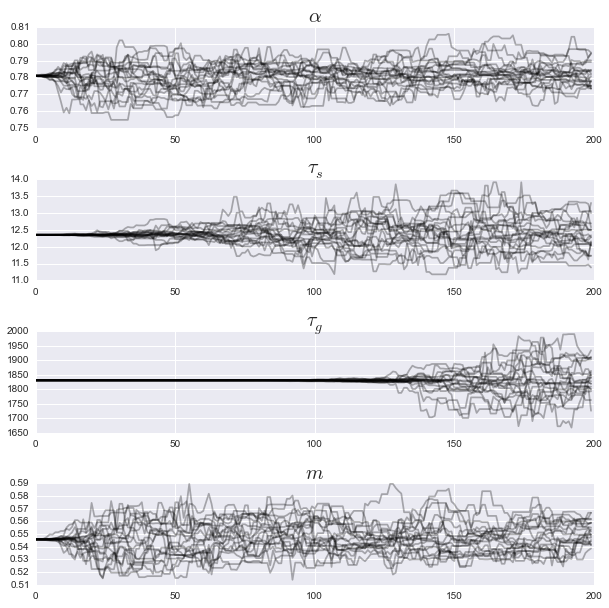

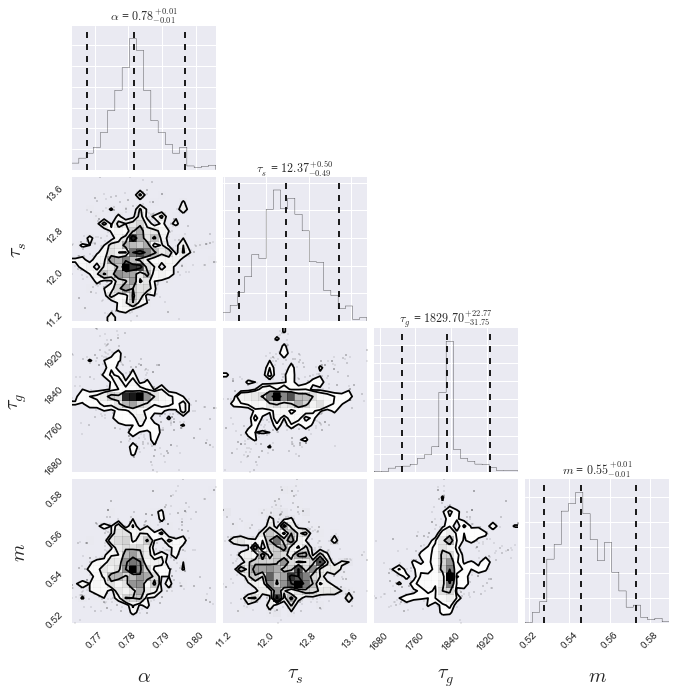

In [23]:
# RUN MCMC

# emcee set-up parameters
n_dim = 4      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard

# Run
samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, met_df, ics, period, truths=None)
# (truths = None because we don't know what answer should be)

In [24]:
# PLOT MEDIAN SIMULATED TIME SERIES AND 95% CREDIBLE INTERVALS, WITH OBSERVED FLOW

# Number of param sets to use
n_sets = 100

# Get uncertainty intervals
param_only, overall = get_uncertainty_intervals(n_sets, samples)

# Get observed data
obs = met_df[['Runoff_mm']].truncate(before='2001-01-01', after=end_dt)

# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(overall.index, overall['2.5%'], overall['97.5%'], 
                 color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(param_only.index, param_only['2.5%'], param_only['97.5%'], 
                 color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(param_only.index, param_only['50%'], 'r-', label='Median simulated')
plt.plot(obs.index, obs['Runoff_mm'], 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

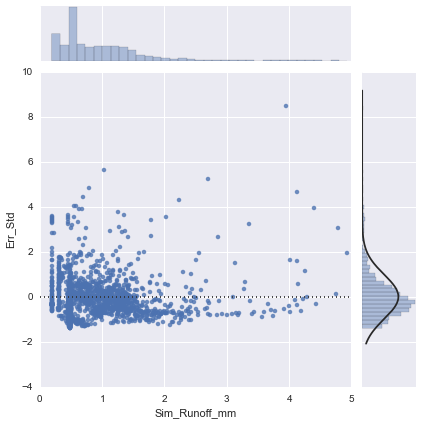

In [25]:
med = plot_residuals(samples)

In [26]:
# CALCULATE COVERAGE & CHECK FOR AUTO-CORRELATION

cov = calc_coverage(med, overall)
print 'Coverage: %.2f' % (cov*100)

pd.tools.plotting.autocorrelation_plot(med['Err_Std'])
# (Solid & dashed grey lines are 95% and 90% confidence bands for AC)

Coverage: 94.87


In [ ]:
param_est = optimize.fmin(neg_log_posterior, init_guess, args=(met_df, max_dict))